<a href="https://colab.research.google.com/github/jvinodraj/theEagle/blob/master/notebooks/analyze_fit_running_economy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 📌 STEP 1: Install required packages
!pip install fitparse pandas --quiet

# 📌 STEP 2: Upload your .fit file
from google.colab import files
uploaded = files.upload()

import io
from fitparse import FitFile
import pandas as pd

# 📌 STEP 3: Parse the FIT file
filename = list(uploaded.keys())[0]
fitfile = FitFile(io.BytesIO(uploaded[filename]))

records = []
for record in fitfile.get_messages('record'):
    record_data = {}
    for record_field in record:
        record_data[record_field.name] = record_field.value
    records.append(record_data)

df = pd.DataFrame(records)

# 📌 STEP 4: Ensure essential fields
required_fields = ['timestamp', 'heart_rate', 'distance', 'power', 'cadence', 'stance_time']
for field in required_fields:
    if field not in df.columns:
        df[field] = None

df = df.dropna(subset=['timestamp', 'distance'])

# Convert distance to kilometers
df['distance_km'] = df['distance'] / 1000

# 📌 STEP 5: Compute speed if not present
df = df.sort_values('timestamp')
df['elapsed_time_sec'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
df['delta_time'] = df['elapsed_time_sec'].diff()
df['delta_dist'] = df['distance_km'].diff()
df['speed_kmph'] = (df['delta_dist'] / df['delta_time']) * 3600  # km/h
df['speed_kmph'] = df['speed_kmph'].fillna(method='bfill').rolling(window=5, min_periods=1).mean()

# 📌 STEP 6: Split into km segments
df['km_split'] = df['distance_km'].astype(int)

# 📌 STEP 7: Aggregate by km
grouped = df.groupby('km_split').agg({
    'timestamp': ['min', 'max'],
    'heart_rate': 'mean',
    'power': 'mean',
    'speed_kmph': 'mean',
    # 'cadence': 'mean',
    'cadence': lambda x: int(x.mean() * 2),
    'stance_time': lambda x: x.dropna().mean()
})

grouped.columns = ['start_time', 'end_time', 'avg_hr', 'avg_power', 'avg_speed_kmph', 'avg_cadence', 'avg_gct']
grouped = grouped.reset_index()

# 📌 STEP 8: Calculate RE using VO2max = 50
VO2max = 50
grouped['RE_ml_kg_km'] = (VO2max * 60) / grouped['avg_speed_kmph']

# Calculate pace and duration
grouped['duration_sec'] = (grouped['end_time'] - grouped['start_time']).dt.total_seconds()
grouped['pace_min_per_km'] = grouped['duration_sec'] / 60

# 📌 Final Output Table
final_df = grouped[['km_split', 'avg_hr', 'avg_power', 'pace_min_per_km',
                    'avg_speed_kmph', 'RE_ml_kg_km', 'avg_cadence', 'avg_gct']]
final_df.columns = ['KM', 'Avg HR', 'Avg Power (W)', 'Pace (min/km)',
                    'Speed (km/h)', 'RE (mL/kg/km)', 'Avg Cadence (spm)', 'Avg GCT (ms)']
final_df = final_df.round(2)

final_df


Saving 5May2025.fit to 5May2025 (5).fit


<ipython-input-9-d0cb0cf7500c>:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['speed_kmph'] = df['speed_kmph'].fillna(method='bfill').rolling(window=5, min_periods=1).mean()


,KM,Avg HR,Avg Power (W),Pace (min/km),Speed (km/h),RE (mL/kg/km),Avg Cadence (spm),Avg GCT (ms)
0,0,123.28,203.13,7.95,7.52,399.16,159,283.81
1,1,131.70,204.58,8.00,7.48,400.85,171,281.66
2,2,132.42,201.56,8.22,7.28,412.00,170,284.62
3,3,134.95,204.46,8.27,7.25,413.93,168,286.74
4,4,132.42,203.66,8.47,7.08,423.75,166,290.62
5,5,132.63,204.12,8.42,7.10,422.41,166,290.54
6,6,132.62,201.54,8.40,7.14,420.05,166,290.36
7,7,127.19,150.91,8.43,5.58,537.30,126,293.42


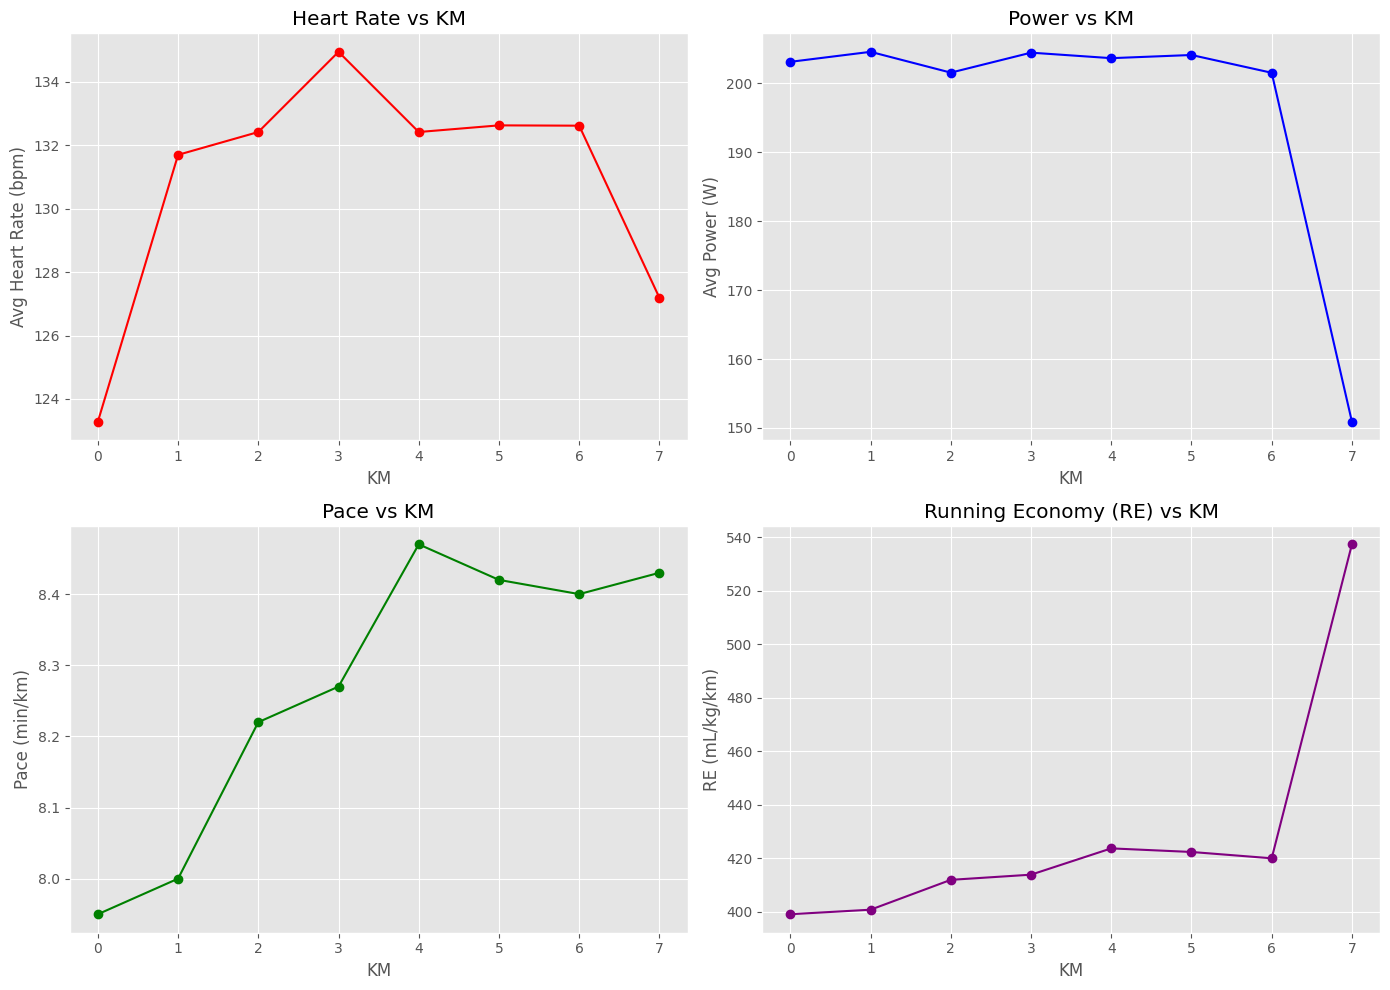

In [6]:
import matplotlib.pyplot as plt

# Set the figure size and style
# plt.style.use('seaborn-darkgrid')
plt.style.use('ggplot')  # or 'default'

plt.figure(figsize=(14, 10))

# Plot 1: Heart Rate
plt.subplot(2, 2, 1)
plt.plot(final_df['KM'], final_df['Avg HR'], marker='o', color='red')
plt.title('Heart Rate vs KM')
plt.xlabel('KM')
plt.ylabel('Avg Heart Rate (bpm)')

# Plot 2: Power
plt.subplot(2, 2, 2)
plt.plot(final_df['KM'], final_df['Avg Power (W)'], marker='o', color='blue')
plt.title('Power vs KM')
plt.xlabel('KM')
plt.ylabel('Avg Power (W)')

# Plot 3: Pace
plt.subplot(2, 2, 3)
plt.plot(final_df['KM'], final_df['Pace (min/km)'], marker='o', color='green')
plt.title('Pace vs KM')
plt.xlabel('KM')
plt.ylabel('Pace (min/km)')

# Plot 4: Running Economy
plt.subplot(2, 2, 4)
plt.plot(final_df['KM'], final_df['RE (mL/kg/km)'], marker='o', color='purple')
plt.title('Running Economy (RE) vs KM')
plt.xlabel('KM')
plt.ylabel('RE (mL/kg/km)')

plt.tight_layout()
plt.show()
